# Black Garlic CNN Modelling via Transfer Learning

In [1]:
import tensorflow as tf
print(tf.keras.__version__)
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('XPU')
physical_devices

2024-08-21 18:16:37.485701: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-21 18:16:37.515793: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 18:16:37.515808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 18:16:37.516521: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 18:16:37.520685: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-21 18:16:37.521207: I tensorflow/core/platform/cpu_feature_guard.cc:1

3.4.1
2.15.0


[PhysicalDevice(name='/physical_device:XPU:0', device_type='XPU')]

## Add functions

In [2]:
#Prep the notebook
#import necessary sources 
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras import layers
from sklearn.metrics import accuracy_score

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import os
import zipfile

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

run_counter=0

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False, name="model"): 
    # Create the confustion matrix
    global run_counter
    run_counter=run_counter+1
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with
    
    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)
    
    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
    
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
    
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.
    
    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                  horizontalalignment="center",
                  color="white" if cm[i, j] > threshold else "black",
                  size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                  horizontalalignment="center",
                  color="white" if cm[i, j] > threshold else "black",
                  size=text_size)
    
    # Save the figure to the current working directory
    if savefig:
        fig.savefig("runs/figs/"+str(run_counter)+"_"+name+"_confusion_matrix.tiff",dpi=300, bbox_inches='tight')
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):

    # Import the target image and preprocess it
    img = load_and_prep_image(filename)
    
    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))
    
    # Get the predicted class
    if len(pred[0]) > 1: # check for multi-class
        pred_class = class_names[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round
    
    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);
  
def plot_loss_curves(history,figsize=(8, 8), model_name=""):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    # Plot loss
    plt.figure(figsize=figsize)
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.savefig("runs/figs/"+str(run_counter)+"_"+model_name+"_loss.tiff",dpi=300,bbox_inches='tight')
    
    # Plot accuracy
    plt.figure(figsize=figsize)
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.savefig("runs/figs/"+str(run_counter)+"_"+model_name+"_accuracy.tiff",dpi=300,bbox_inches='tight')

def compare_historys(original_history, new_history, initial_epochs=5, model_name=""):

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    #plt.show()
    plt.savefig("runs/figs/"+str(run_counter)+"_"+model_name+"_tuned_history.tiff",dpi=300,bbox_inches='tight')
  
def unzip_data(filename):
    zip_ref = zipfile.ZipFile(filename, "r")
    zip_ref.extractall()
    zip_ref.close()

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

def plot_all_curves(history=[],new_history=[],figsize=(10, 5), initial_epochs=10,model_name="",train_val=""):
    param_loss = ""
    param_accu = ""
    title_loss = ""
    title_accu = ""
    
    if train_val == "train":
        param_loss = "loss"
        param_accu = "accuracy"
        title_loss = "Training Loss"
        title_accu = "Training Accuracy"
    else:
        param_loss = "val_loss"
        param_accu = "val_accuracy"
        title_loss = "Validation Loss"
        title_accu = "Validation Accuracy"
        
    vloss1 = history[0].history[param_loss]
    vloss2 = vloss1 + new_history[0].history[param_loss]
    vloss3 =history[1].history[param_loss]
    vloss4 =vloss3 + new_history[1].history[param_loss]
    vloss5 =history[2].history[param_loss]
    vloss6 =vloss5 + new_history[2].history[param_loss]
    vloss7 =history[4].history[param_loss]
    vloss8 =vloss7 + new_history[3].history[param_loss]
    vloss9 =history[4].history[param_loss]
    vloss10 =vloss9 + new_history[4].history[param_loss]
    vloss11 =history[5].history[param_loss]
    vloss12 =vloss11 + new_history[5].history[param_loss]
    vloss13 =history[6].history[param_loss]
    vloss14 =vloss13 + new_history[6].history[param_loss]
    vloss15 =history[7].history[param_loss]
    vloss16 =vloss15 + new_history[7].history[param_loss]


    
    vaccu1 = history[0].history[param_accu]
    vaccu2 = vaccu1 + new_history[0].history[param_accu]
    vaccu3 = history[1].history[param_accu]
    vaccu4 = vaccu3 + new_history[1].history[param_accu]
    vaccu5 = history[2].history[param_accu]
    vaccu6 = vaccu5 + new_history[2].history[param_accu]
    vaccu7 = history[3].history[param_accu]
    vaccu8 = vaccu7 + new_history[3].history[param_accu]
    vaccu9 = history[4].history[param_accu]
    vaccu10 = vaccu9 + new_history[4].history[param_accu]
    vaccu11 = history[5].history[param_accu]
    vaccu12 = vaccu11 + new_history[5].history[param_accu]
    vaccu13 = history[6].history[param_accu]
    vaccu14 = vaccu13 + new_history[6].history[param_accu]
    vaccu15 = history[7].history[param_accu]
    vaccu16 = vaccu15 + new_history[7].history[param_accu]
    
    # Plot loss
    plt.figure(figsize=figsize)
    plt.plot(vloss1, label='VGG16',color="#e6194B")
    plt.plot(vloss2, label='VGG16-tuned',color="#e6194B")
    plt.plot(vloss3, label='VGG16-augmented',color="#ffe119")
    plt.plot(vloss4, label='VGG16-augmented-tuned',color="#ffe119")
    plt.plot(vloss5, label='ResNet50v2',color="#3cb44b")
    plt.plot(vloss6, label='ResNet50v2-tuned',color="#3cb44b")
    plt.plot(vloss7, label='ResNet50v2-augmented',color="#4363d8")
    plt.plot(vloss8, label='ResNet50v2-augmented-tuned',color="#4363d8")
    plt.plot(vloss9, label='EfficientNetB0',color="#f032e6")
    plt.plot(vloss10, label='EfficientNetB0-tuned',color="#f032e6")
    plt.plot(vloss11, label='EfficientNetB0-augmented',color="#800000")
    plt.plot(vloss12, label='EfficientNetB0-augmented-tuned',color="#800000")
    #new    
    plt.plot(vloss13, label='MobileNetV2',color="#f5b042")
    plt.plot(vloss14, label='MobileNetV2-tuned',color="#f5b042")
    plt.plot(vloss15, label='MobileNetV2-augmented',color="#9e9e9e")
    plt.plot(vloss16, label='MobileNetV2-augmented-tuned',color="#9e9e9e")
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.title(title_loss)
    plt.xlabel('Epochs')
    plt.legend(fontsize=8)
    plt.savefig("runs/figs/"+str(run_counter)+"_"+model_name+"_"+param_loss+".tiff",dpi=300,bbox_inches='tight')
    
    # Plot accuracy
    plt.figure(figsize=figsize)
    plt.plot(vaccu1, label='VGG16',color="#e6194B")
    plt.plot(vaccu2, label='VGG16-tuned',color="#e6194B")
    plt.plot(vaccu3, label='VGG16-augmented',color="#ffe119")
    plt.plot(vaccu4, label='VGG16-augmented-tuned',color="#ffe119")
    plt.plot(vaccu5, label='ResNet50v2',color="#3cb44b")
    plt.plot(vaccu6, label='ResNet50v2-tuned',color="#3cb44b")
    plt.plot(vaccu7, label='ResNet50v2-augmented',color="#4363d8")
    plt.plot(vaccu8, label='ResNet50v2-augmented-tuned',color="#4363d8")
    plt.plot(vaccu9, label='EfficientNetB0',color="#f032e6")
    plt.plot(vaccu10, label='EfficientNetB0-tuned',color="#f032e6")
    plt.plot(vaccu11, label='EfficientNetB0-augmented',color="#800000")
    plt.plot(vaccu12, label='EfficientNetB0-augmented-tuned',color="#800000")
    #new
    plt.plot(vaccu13, label='MobileNetV2',color="#f5b042")
    plt.plot(vaccu14, label='MobileNetV2-tuned',color="#f5b042")
    plt.plot(vaccu15, label='MobileNetV2-augmented',color="#9e9e9e")
    plt.plot(vaccu16, label='MobileNetV2-augmented-tuned',color="#9e9e9e")
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.title(title_accu)
    plt.xlabel('Epochs')
    plt.legend(fontsize=8)
    plt.savefig("runs/figs/"+str(run_counter)+"_"+model_name+"_"+param_accu+".tiff",dpi=300,bbox_inches='tight')
    

In [3]:
#Script to generate important details and figures
res = []
def generate_details(model,test_data,history,tuned=False):
    print("Evaluating...")
    loaded_loss, loaded_accuracy = model.evaluate(test_data)
    loaded_loss, loaded_accuracy
    print("done.")
    #make predictions usind the model
    print("Predicting...")
    pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take
    print("done.")

    #save the evaluation results for tabulation
    res.append([model.name,round(loaded_loss*100,4),round(loaded_accuracy*100,4)])
    
    # Get the class predicitons of each label
    pred_classes = pred_probs.argmax(axis=1)
    
    # How do they look?
    pred_classes[:10]
    
    # make labels using unbatch
    y_labels = []
    for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
      y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
    y_labels[:10] # check what they look like (unshuffled)
    
    # Get accuracy score by comparing predicted classes to ground truth labels
    sklearn_accuracy = accuracy_score(y_labels, pred_classes)
    sklearn_accuracy
    
    # Does the evaluate method compare to the Scikit-Learn measured accuracy?
    import numpy as np
    print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")
    
    # Get the class names
    class_names = test_data.class_names
    class_names[:10]
    
    #Genrate the confusion matrix
    make_confusion_matrix(y_true=y_labels,
                          y_pred=pred_classes,
                          classes=class_names,
                          figsize=(5, 5),
                          text_size=10,
                          norm=True,#with percentage
                          savefig=True,
                          name=model.name)
    if tuned:
        #plot hystorys
        compare_historys(original_history=history[0],
                         new_history=history[1],
                         initial_epochs=history[2],
                         model_name=model.name)
    else:
        #Plot the curves
        plot_loss_curves(history[0],figsize=(6, 3), model_name=model.name)


# Setup checkpoint path
def setup_checkpoint(model_name):
    weights_checkpoint_path = "runs/checkpoints/"+model_name+".weights.h5"
    model_checkpoint_path = "runs/checkpoints/"+model_name+"model.keras" 
    
    # Create a ModelCheckpoint callback that saves the model's weights only
    weights_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=weights_checkpoint_path,
                                                             save_weights_only=True, # set to False to save the entire model
                                                             save_best_only=True, # save only the best model weights instead of a model every epoch
                                                             save_freq="epoch", # save every epoch
                                                             verbose=1)
    
    # Create a ModelCheckpoint callback that saves the whole model
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_path,
                                                             save_best_only=True, # save only the best model weights instead of a model every epoch
                                                             save_freq="epoch", # save every epoch
                                                             verbose=1)
    
    return (weights_checkpoint_callback, weights_checkpoint_path)

def setup_csvlogger(model_name):
    path = "runs/csv/"+model_name+".csv"
    csv_logger = tf.keras.callbacks.CSVLogger(path)
    return csv_logger
    
#results printer
def show_results(results):
    all_results = pd.DataFrame(results, columns=["Model", "Loss", "Accuracy"])
    all_results.to_csv('runs/RESULTS.csv')
    return all_results

## Data Preparation

In [4]:

#inspect the dataset directory
walk_through_dir("black_garlic_main")

# Create training, validation and test directories
train_dir = "black_garlic_main/train/"
test_dir = "black_garlic_main/test/"
val_dir = "black_garlic_main/val/"

# Create data inputs
IMG_SIZE = (224, 224) # define image size
train_data = keras.utils.image_dataset_from_directory(directory=train_dir,
                                                      image_size=IMG_SIZE,
                                                      label_mode="categorical",
                                                      batch_size=32)
test_data = keras.utils.image_dataset_from_directory(directory=test_dir,
                                                     image_size=IMG_SIZE,
                                                     label_mode="categorical",
                                                     batch_size=32,
                                                     shuffle=False)
val_data = keras.utils.image_dataset_from_directory(directory=val_dir,
                                                    image_size=IMG_SIZE,
                                                    batch_size=32,
                                                    label_mode="categorical",
                                                    shuffle=True)


There are 3 directories and 0 images in 'black_garlic_main'.
There are 3 directories and 0 images in 'black_garlic_main/train'.
There are 0 directories and 370 images in 'black_garlic_main/train/underaged'.
There are 0 directories and 370 images in 'black_garlic_main/train/overaged'.
There are 0 directories and 370 images in 'black_garlic_main/train/excellent'.
There are 3 directories and 0 images in 'black_garlic_main/test'.
There are 0 directories and 20 images in 'black_garlic_main/test/underaged'.
There are 0 directories and 20 images in 'black_garlic_main/test/overaged'.
There are 0 directories and 20 images in 'black_garlic_main/test/excellent'.
There are 3 directories and 0 images in 'black_garlic_main/val'.
There are 0 directories and 65 images in 'black_garlic_main/val/underaged'.
There are 0 directories and 65 images in 'black_garlic_main/val/overaged'.
There are 0 directories and 65 images in 'black_garlic_main/val/excellent'.
Found 1110 files belonging to 3 classes.


2024-08-21 18:16:39.833444: I tensorflow/core/common_runtime/next_pluggable_device/next_pluggable_device_factory.cc:118] Created 1 TensorFlow NextPluggableDevices. Physical device type: XPU


Found 60 files belonging to 3 classes.
Found 195 files belonging to 3 classes.


In [5]:
class_names = test_data.class_names
class_names

['excellent', 'overaged', 'underaged']

# Model 1 EfficientNetB0

In [6]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(3, activation="softmax", name="output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)
              
model_1.name="Model_1_EfficientNetB0"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_1.name)
logger = setup_csvlogger(model_1.name)

history1 = model_1.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback,logger]
                      )

Epoch 1/10


2024-08-21 18:16:44.389581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type XPU is enabled.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.4557 - loss: 1.0276
Epoch 1: val_loss improved from inf to 0.67438, saving model to runs/checkpoints/Model_1_EfficientNetB0.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 284ms/step - accuracy: 0.4592 - loss: 1.0244 - val_accuracy: 0.7897 - val_loss: 0.6744
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8206 - loss: 0.6267
Epoch 2: val_loss improved from 0.67438 to 0.46751, saving model to runs/checkpoints/Model_1_EfficientNetB0.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 192ms/step - accuracy: 0.8210 - loss: 0.6257 - val_accuracy: 0.8923 - val_loss: 0.4675
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8762 - loss: 0.4708
Epoch 3: val_loss improved from 0.46751 to 0.36043, saving model to runs/checkpoints/Model_1_EfficientNetB0.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.8761 - loss: 0.4704 - val_accuracy: 0.9385 - val_loss: 0.3604
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/s

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.1403  
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
done.
Close? False | Difference: 0.06666660706202188


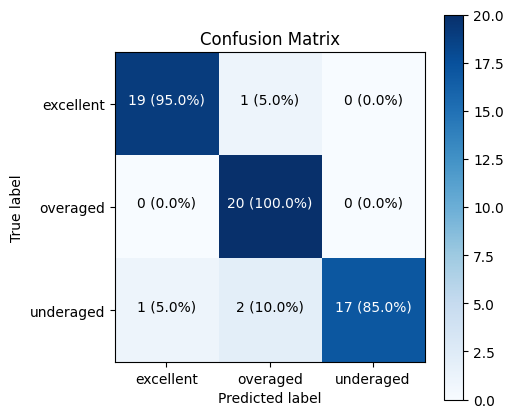

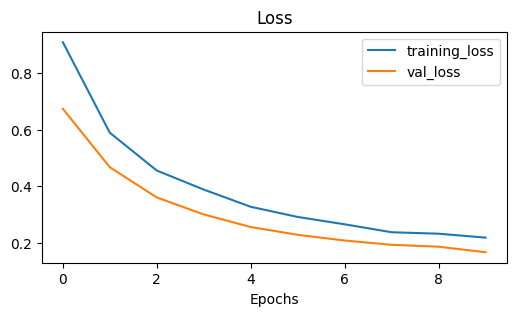

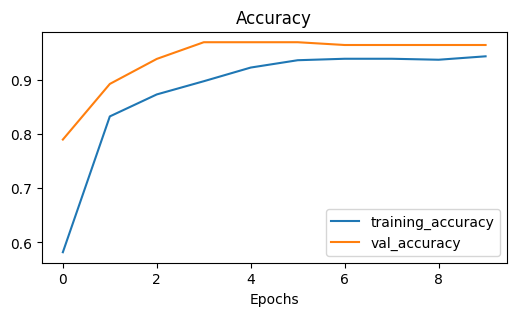

In [7]:
#Generate needed details
model_1.load_weights(checkpoint_path)
generate_details(model_1,test_data,[history1])

# Model 1 EfficientNetB0 with fine-tuning

In [8]:
model_1.load_weights(checkpoint_path)
model_1.layers[1].trainable = False

for layer in model_1.layers[1].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #set lower training rate
              metrics=["accuracy"],
              jit_compile = False)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
model_1.name="Model_1_EfficientNetB0_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_1.name)
logger = setup_csvlogger(model_1.name)

history1_tuned = model_1.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history1.epoch[-1], 
                             callbacks=[checkpoint_callback,logger]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9295 - loss: 0.2441
Epoch 10: val_loss improved from inf to 0.10356, saving model to runs/checkpoints/Model_1_EfficientNetB0_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - accuracy: 0.9299 - loss: 0.2429 - val_accuracy: 0.9744 - val_loss: 0.1036
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9628 - loss: 0.1249
Epoch 11: val_loss improved from 0.10356 to 0.07646, saving model to runs/checkpoints/Model_1_EfficientNetB0_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.9629 - loss: 0.1250 - val_accuracy: 0.9795 - val_loss: 0.0765
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9752 - loss: 0.1001
Epoch 12: val_loss improved from 0.07646 to 0.07287, saving model to runs/checkpoints/Model_1_EfficientNetB0_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.9752 - loss: 0.1000 - val_accuracy: 0.9744

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 0.0154
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
done.
Close? True | Difference: -5.960464477539063e-08


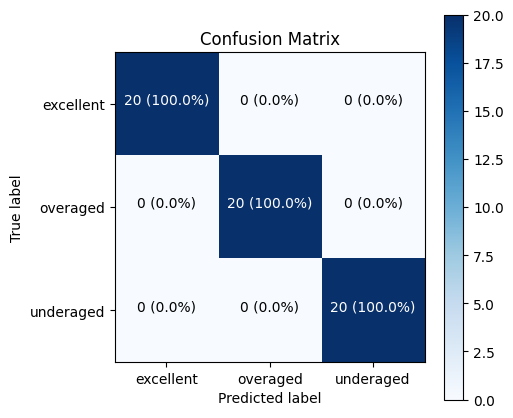

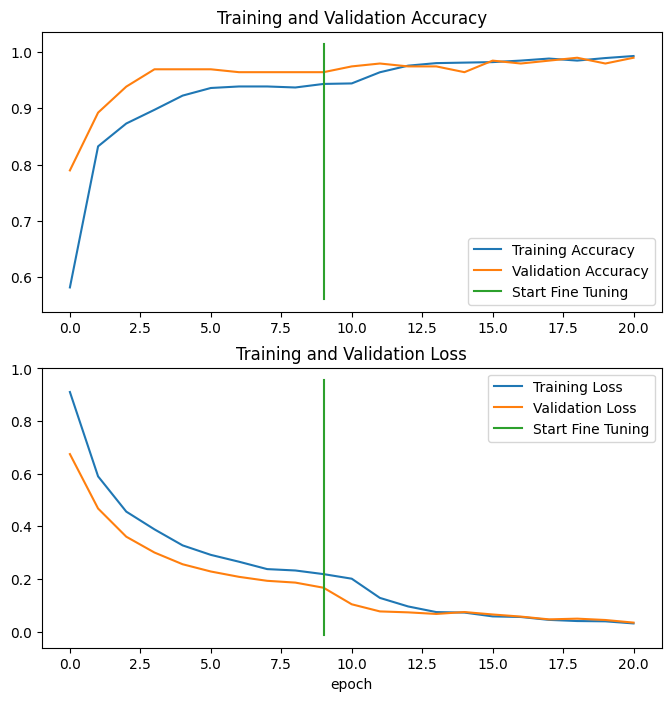

In [9]:
#Generate needed details
model_1.load_weights(checkpoint_path)
generate_details(model_1,test_data,[history1,history1_tuned,10],True)

# Model 2 EfficientNetB0 with augmentation

In [10]:
data_augmentation = keras.Sequential([
  layers.RandomZoom(0.1,0.3),
  layers.RandomFlip("horizontal"),
], name ="data_augmentation")

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)
model_2 = keras.Model(inputs, outputs)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)
model_2.name="Model_2_EfficientNetB0_with_augmentation"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_2.name)
logger = setup_csvlogger(model_2.name)

history2 = model_2.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback,logger]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.4837 - loss: 1.0057
Epoch 1: val_loss improved from inf to 0.75859, saving model to runs/checkpoints/Model_2_EfficientNetB0_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 255ms/step - accuracy: 0.4866 - loss: 1.0033 - val_accuracy: 0.7128 - val_loss: 0.7586
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.7903 - loss: 0.6781
Epoch 2: val_loss improved from 0.75859 to 0.56526, saving model to runs/checkpoints/Model_2_EfficientNetB0_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - accuracy: 0.7905 - loss: 0.6773 - val_accuracy: 0.8308 - val_loss: 0.5653
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8382 - loss: 0.5546
Epoch 3: val_loss improved from 0.56526 to 0.46932, saving model to runs/checkpoints/Model_2_EfficientNetB0_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - accuracy: 0.8383 - loss: 0.5539 - val_accuracy: 0.8308 - 

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9132 - loss: 0.2142
done.
Predicting...
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f4b0e2a2d30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
done.
Close? False | Difference: 0.1499999602635701


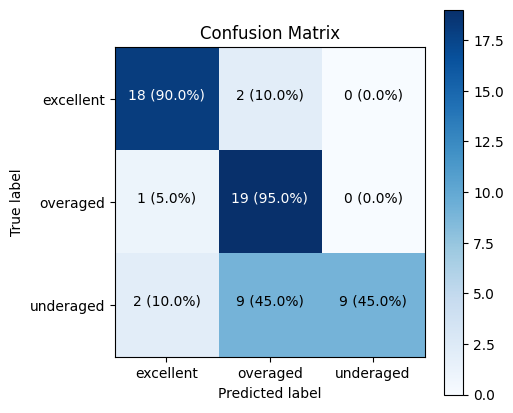

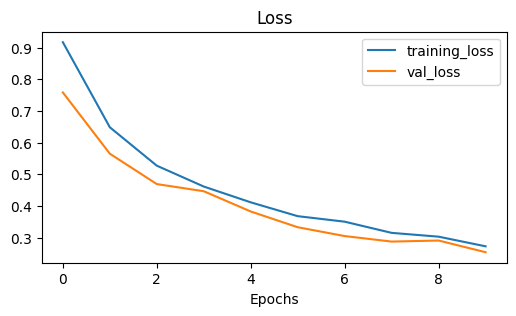

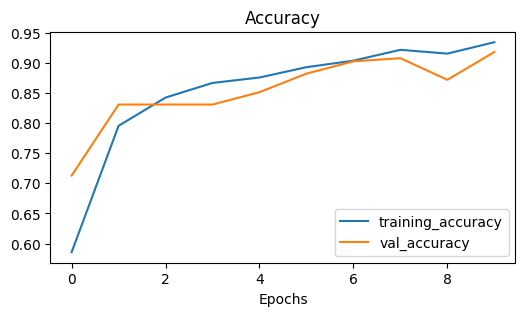

In [11]:
#Generate needed details
model_2.load_weights(checkpoint_path)
generate_details(model_2,test_data,[history2])

# Model 2 EfficientNetB0 with augmentation and fine-tuning

In [12]:
model_2.load_weights(checkpoint_path)
model_2.layers[2].trainable = False

for layer in model_2.layers[2].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #set lower training rate
              metrics=["accuracy"],
              jit_compile = False)

model_2.name = "Model_2_EfficientNetB0_with_augmentation_and_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_2.name)
logger = setup_csvlogger(model_2.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history2_tuned = model_2.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history2.epoch[-1],
                             callbacks=[checkpoint_callback,logger]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8935 - loss: 0.3121
Epoch 10: val_loss improved from inf to 0.16894, saving model to runs/checkpoints/Model_2_EfficientNetB0_with_augmentation_and_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 262ms/step - accuracy: 0.8943 - loss: 0.3103 - val_accuracy: 0.9436 - val_loss: 0.1689
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9290 - loss: 0.1870
Epoch 11: val_loss improved from 0.16894 to 0.14638, saving model to runs/checkpoints/Model_2_EfficientNetB0_with_augmentation_and_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.9294 - loss: 0.1863 - val_accuracy: 0.9385 - val_loss: 0.1464
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9599 - loss: 0.1247
Epoch 12: val_loss improved from 0.14638 to 0.12663, saving model to runs/checkpoints/Model_2_EfficientNetB0_with_augmentation_and_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 234ms/step - acc

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9569 - loss: 0.0814
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
done.
Close? True | Difference: -8.74201456779744e-08


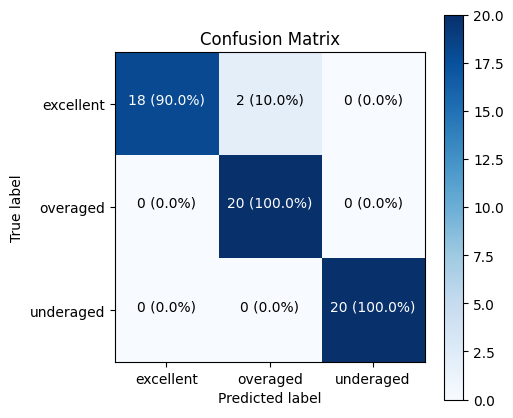

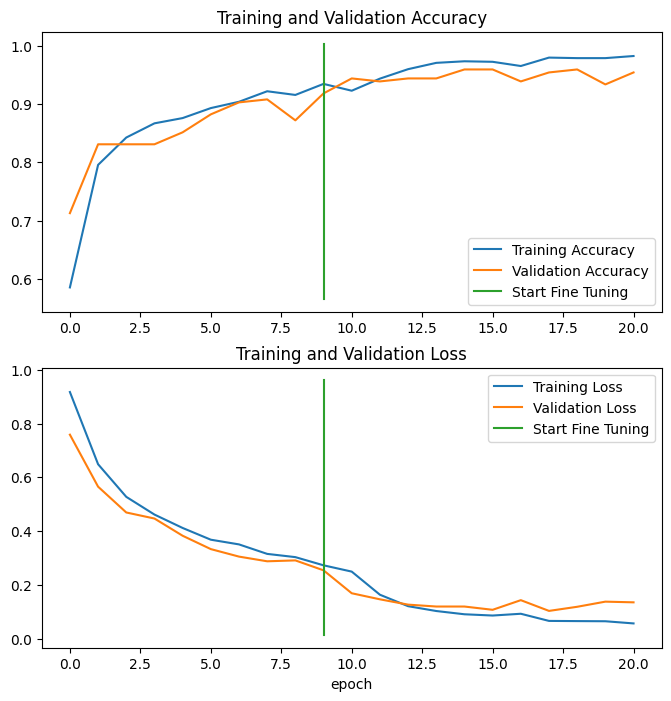

In [13]:
#Generate needed details
model_2.load_weights(checkpoint_path)
generate_details(model_2,test_data,[history2,history2_tuned,10],True)

# Model 3 ResNet50v2

In [14]:
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = layers.Rescaling(1./255,name="rescaler")(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation="softmax", name="output_layer")(x)
model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_3.name = "Model_3_ResNet50v2"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_3.name)
logger = setup_csvlogger(model_3.name)

history3 = model_3.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback,logger]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3964 - loss: 1.5734
Epoch 1: val_loss improved from inf to 0.72393, saving model to runs/checkpoints/Model_3_ResNet50v2.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.3984 - loss: 1.5644 - val_accuracy: 0.7128 - val_loss: 0.7239
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6377 - loss: 0.7295
Epoch 2: val_loss improved from 0.72393 to 0.50097, saving model to runs/checkpoints/Model_3_ResNet50v2.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.6200 - loss: 0.7093 - val_accuracy: 0.8308 - val_loss: 0.5010
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7664 - loss: 0.5359
Epoch 3: val_loss improved from 0.50097 to 0.43013, saving model to runs/checkpoints/Model_3_ResNet50v2.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.7668 - loss: 0.5356 - val_accuracy: 0.8615 - val_loss: 0.4301
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/st

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step - accuracy: 0.9347 - loss: 0.1986
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 935ms/step
done.
Close? True | Difference: -5.563100180516756e-08


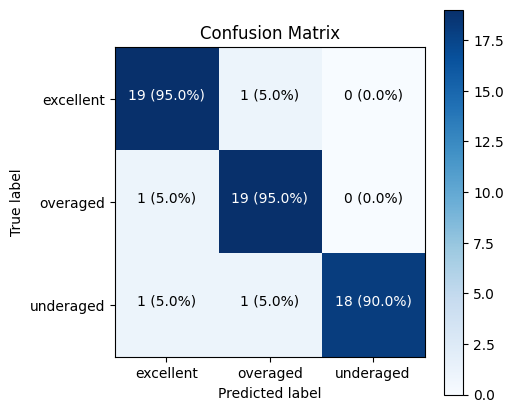

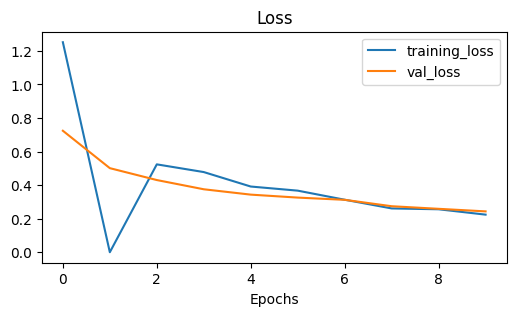

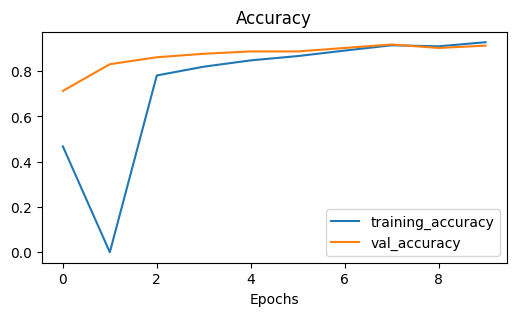

In [15]:
#Generate needed details
model_3.load_weights(checkpoint_path)
generate_details(model_3,test_data,[history3])

# Model 3 ResNet50v2 with fine-tuning

In [16]:
model_3.load_weights(checkpoint_path)
model_3.layers[2].trainable = False

for layer in model_3.layers[2].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #set lower training rate 0.001 is default
              metrics=["accuracy"],
              jit_compile = False)

model_3.name = "Model_3_ResNet50v2_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_3.name)
logger = setup_csvlogger(model_3.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history3_tuned = model_3.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history3.epoch[-1],
                             callbacks=[checkpoint_callback,logger]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.8511 - loss: 0.4045
Epoch 10: val_loss improved from inf to 0.14215, saving model to runs/checkpoints/Model_3_ResNet50v2_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.8523 - loss: 0.4012 - val_accuracy: 0.9436 - val_loss: 0.1422
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9772 - loss: 0.0855
Epoch 11: val_loss did not improve from 0.14215
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9768 - loss: 0.0858 - val_accuracy: 0.3436 - val_loss: 4.7100
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.4713 - loss: 2.2725
Epoch 12: val_loss did not improve from 0.14215
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.4736 - loss: 2.2513 - val_accuracy: 0.8359 - val_loss: 0.4248
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7702 - loss: 0.5242
Epoch 13: val_loss did not improve from 0.14215
35/35 ━━━━━━━━━━━━━━━━━━━━ 

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9458 - loss: 0.1221
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 931ms/step
done.
Close? False | Difference: 0.01666659514109292


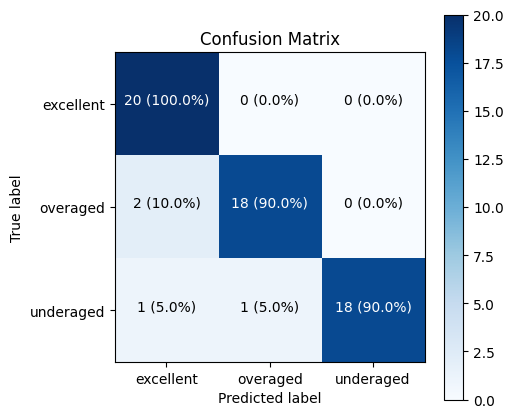

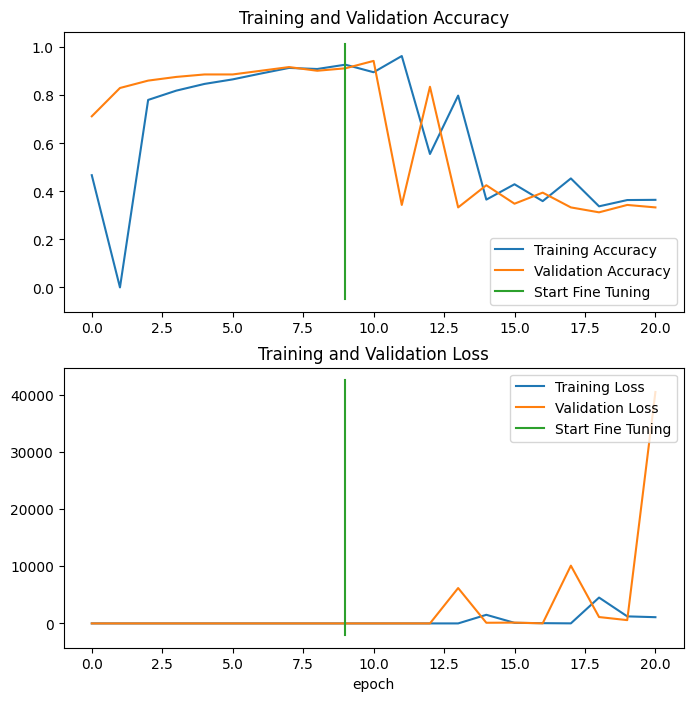

In [17]:
#Generate needed details
model_3.load_weights(checkpoint_path)
generate_details(model_3,test_data,[history3,history3_tuned,10],True)

# Model 4 ResNet50v2 with augmentation

In [18]:
data_augmentation = keras.Sequential([
  layers.RandomZoom(0.1,0.1),
  layers.RandomFlip("horizontal"),
], name ="data_augmentation")
input_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)
x = layers.Rescaling(1./255, name="rescaler")(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)
model_4 = keras.Model(inputs, outputs)
model_4.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_4.name = "Model_4_ResNet50v2_with_augmentation"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_4.name)
logger = setup_csvlogger(model_4.name)

history4 = model_4.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback,logger]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.4430 - loss: 1.3182
Epoch 1: val_loss improved from inf to 0.69528, saving model to runs/checkpoints/Model_4_ResNet50v2_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - accuracy: 0.4446 - loss: 1.3129 - val_accuracy: 0.6872 - val_loss: 0.6953
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.6890 - loss: 0.7199
Epoch 2: val_loss improved from 0.69528 to 0.46241, saving model to runs/checkpoints/Model_4_ResNet50v2_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.6897 - loss: 0.7189 - val_accuracy: 0.8410 - val_loss: 0.4624
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7869 - loss: 0.5560
Epoch 3: val_loss improved from 0.46241 to 0.40824, saving model to runs/checkpoints/Model_4_ResNet50v2_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.7867 - loss: 0.5555 - val_accuracy: 0.8615 - val_loss: 0.

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9451 - loss: 0.2264
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 930ms/step
done.
Close? True | Difference: -5.563100180516756e-08


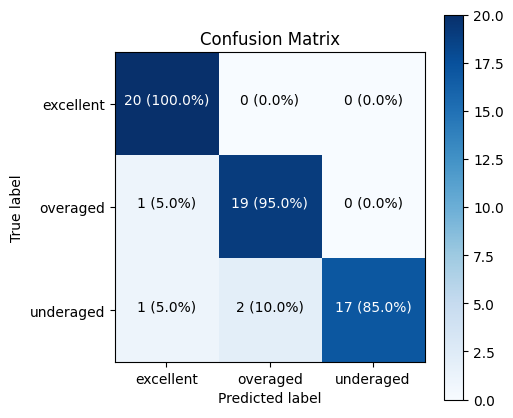

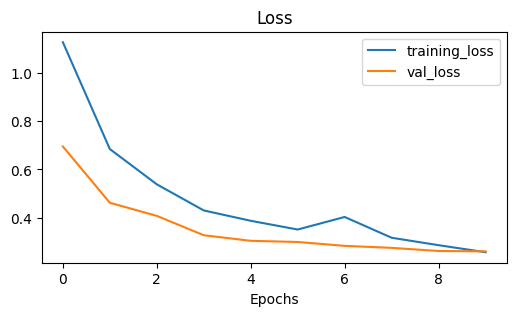

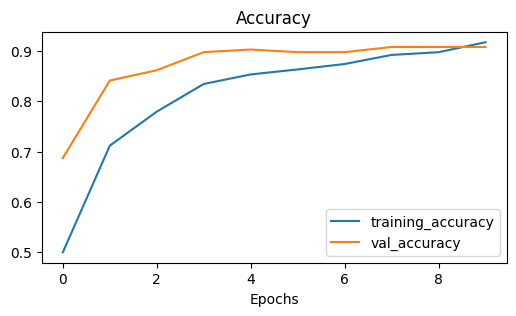

In [19]:
#Generate needed details
model_4.load_weights(checkpoint_path)
generate_details(model_4,test_data,[history4])

# Model 4 ResNet50v2 with augmentation with fine-tuning

In [20]:
model_4.load_weights(checkpoint_path)
model_4.layers[3].trainable = False

for layer in model_4.layers[3].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), #set lower training rate
              metrics=["accuracy"],
              jit_compile = False)

model_4.name = "Model_4_ResNet50v2_with_augmentation_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_4.name)
logger = setup_csvlogger(model_4.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history4_tuned = model_4.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history4.epoch[-1],
                             callbacks=[checkpoint_callback,logger]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8675 - loss: 0.3310
Epoch 10: val_loss improved from inf to 0.23526, saving model to runs/checkpoints/Model_4_ResNet50v2_with_augmentation_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.8681 - loss: 0.3300 - val_accuracy: 0.9128 - val_loss: 0.2353
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9422 - loss: 0.1749
Epoch 11: val_loss did not improve from 0.23526
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.9425 - loss: 0.1742 - val_accuracy: 0.9179 - val_loss: 0.2492
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9253 - loss: 0.2033
Epoch 12: val_loss did not improve from 0.23526
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.9252 - loss: 0.2030 - val_accuracy: 0.8615 - val_loss: 0.3278
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8588 - loss: 0.3203
Epoch 13: val_loss improved from 0.23526 to 0.17996, savi

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9674 - loss: 0.0997
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 931ms/step
done.
Close? True | Difference: -8.74201456779744e-08


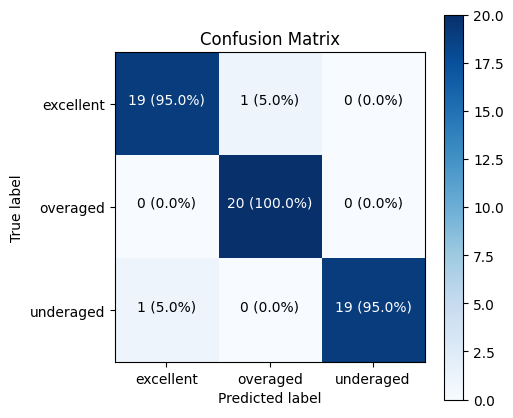

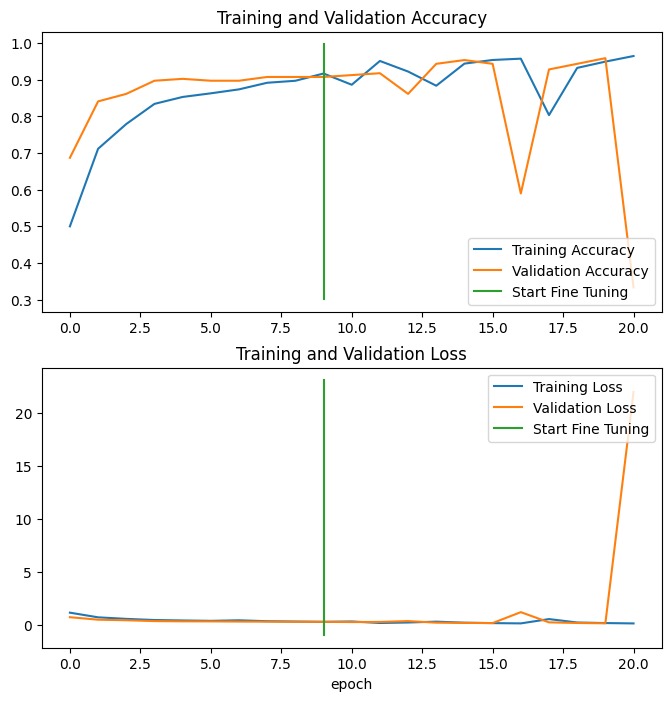

In [21]:
#Generate needed details
model_4.load_weights(checkpoint_path)
generate_details(model_4,test_data,[history4,history4_tuned,10],True)

# Model 5 VGG16

In [22]:
base_model = tf.keras.applications.VGG16(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = layers.Rescaling(1./255)(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(3, activation="softmax", name="output_layer")(x)
model_5 = tf.keras.Model(inputs, outputs)
model_5.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_5.name = "Model_5_VGG16"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_5.name)
logger = setup_csvlogger(model_5.name)

history5 = model_5.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback,logger]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.3438 - loss: 1.1512
Epoch 1: val_loss improved from inf to 1.09986, saving model to runs/checkpoints/Model_5_VGG16.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.3437 - loss: 1.1504 - val_accuracy: 0.3590 - val_loss: 1.0999
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.3399 - loss: 1.0990
Epoch 2: val_loss improved from 1.09986 to 1.08419, saving model to runs/checkpoints/Model_5_VGG16.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.3409 - loss: 1.0988 - val_accuracy: 0.4103 - val_loss: 1.0842
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.4280 - loss: 1.0823
Epoch 3: val_loss improved from 1.08419 to 1.07557, saving model to runs/checkpoints/Model_5_VGG16.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.4278 - loss: 1.0822 - val_accuracy: 0.4051 - val_loss: 1.0756
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step - accuracy: 0.6618 - loss: 0.9810
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
done.
Close? True | Difference: -7.947285940446136e-09


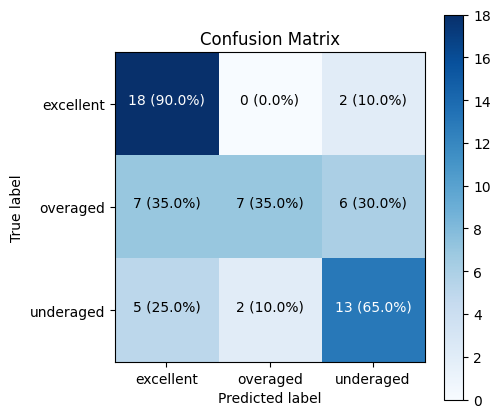

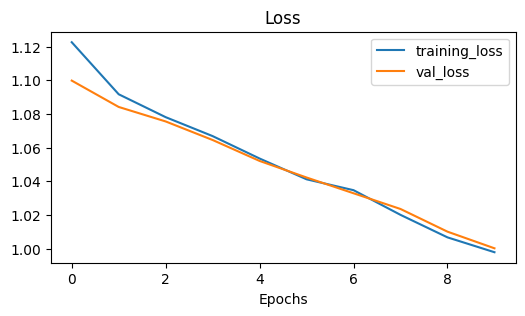

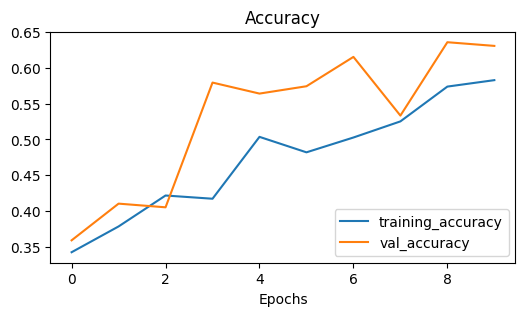

In [23]:
#Generate needed details
model_5.load_weights(checkpoint_path)
generate_details(model_5,test_data,[history5])

# Model 5 VGG16 with fine-tuning

In [24]:
model_5.load_weights(checkpoint_path)
model_5.layers[2].trainable = False

for layer in model_5.layers[2].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_5.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00007), #set lower training rate 0.001 is default
              metrics=["accuracy"],
              jit_compile = False)

model_5.name = "Model_5_VGG16_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_5.name)
logger = setup_csvlogger(model_5.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history5_tuned = model_5.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history5.epoch[-1],
                             callbacks=[checkpoint_callback,logger]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.5788 - loss: 0.9279
Epoch 10: val_loss improved from inf to 0.33614, saving model to runs/checkpoints/Model_5_VGG16_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.5816 - loss: 0.9217 - val_accuracy: 0.8667 - val_loss: 0.3361
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8947 - loss: 0.2394
Epoch 11: val_loss improved from 0.33614 to 0.10254, saving model to runs/checkpoints/Model_5_VGG16_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.8954 - loss: 0.2381 - val_accuracy: 0.9641 - val_loss: 0.1025
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9607 - loss: 0.1086
Epoch 12: val_loss improved from 0.10254 to 0.07296, saving model to runs/checkpoints/Model_5_VGG16_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.9607 - loss: 0.1086 - val_accuracy: 0.9641 - val_loss: 0.0730
Epoch 1

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9785 - loss: 0.0191
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
done.
Close? True | Difference: -4.371007278347605e-08


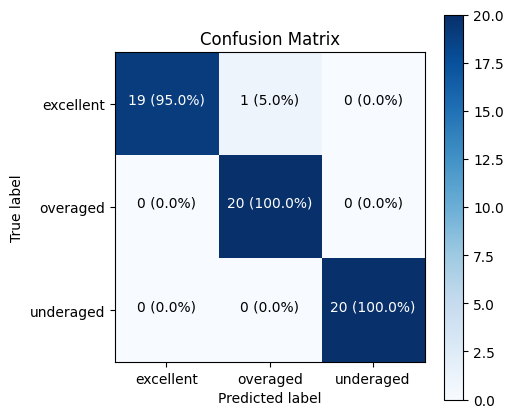

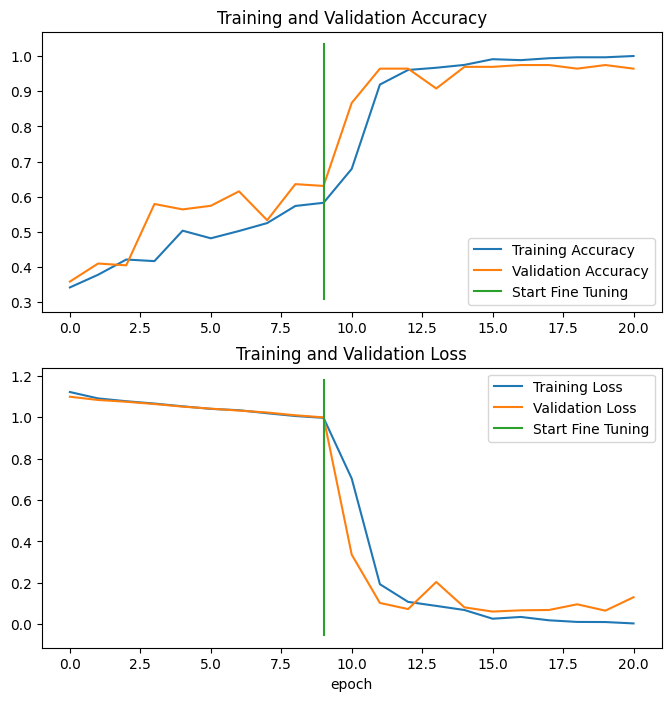

In [25]:
#Generate needed details
model_5.load_weights(checkpoint_path)
generate_details(model_5,test_data,[history5,history5_tuned,10],True)

# Model 6 VGG16 with augmentation

In [26]:
data_augmentation = keras.Sequential([
  layers.RandomZoom(0.1,0.3),
  layers.RandomFlip("horizontal"),
], name ="data_augmentation")

input_shape = (224, 224, 3)
base_model = tf.keras.applications.VGG16(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = layers.Rescaling(1./255, name="rescaler")(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)
model_6 = keras.Model(inputs, outputs)

model_6.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_6.name = "Model_6_VGG16_with_augmentation"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_6.name)
logger = setup_csvlogger(model_6.name)

history6 = model_6.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback,logger]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3179 - loss: 1.1129
Epoch 1: val_loss improved from inf to 1.09784, saving model to runs/checkpoints/Model_6_VGG16_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.3180 - loss: 1.1127 - val_accuracy: 0.3846 - val_loss: 1.0978
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.3552 - loss: 1.0965
Epoch 2: val_loss improved from 1.09784 to 1.08705, saving model to runs/checkpoints/Model_6_VGG16_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.3555 - loss: 1.0963 - val_accuracy: 0.4821 - val_loss: 1.0870
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4212 - loss: 1.0831
Epoch 3: val_loss improved from 1.08705 to 1.07544, saving model to runs/checkpoints/Model_6_VGG16_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.4218 - loss: 1.0829 - val_accuracy: 0.4667 - val_loss: 1.0754
Epoch 4/10


Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4472 - loss: 1.0272
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
done.
Close? True | Difference: -4.37100728389872e-08


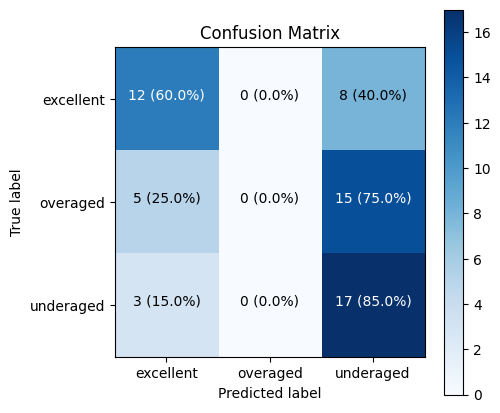

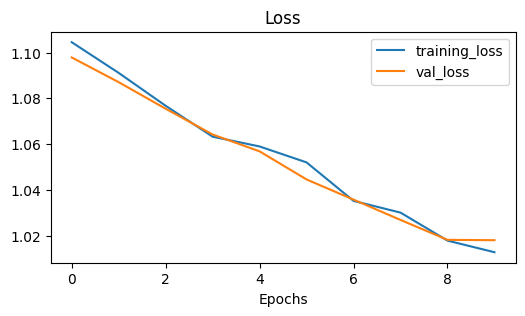

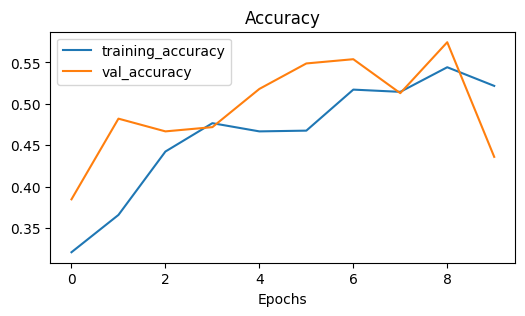

In [27]:
#Generate needed details
model_6.load_weights(checkpoint_path)
generate_details(model_6,test_data,[history6])

# Model 6 VGG16 with augmentation and fine-tuning

In [28]:
model_6.load_weights(checkpoint_path)
model_6.layers[3].trainable = False

for layer in model_6.layers[3].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_6.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00007), #set lower training rate
              metrics=["accuracy"])

model_6.name = "Model_6_VGG16_with_augmentation_and_fine-tuningn"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_6.name)
logger = setup_csvlogger(model_6.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history6_tuned = model_6.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history6.epoch[-1],
                             callbacks=[checkpoint_callback,logger]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5129 - loss: 0.9886
Epoch 10: val_loss improved from inf to 0.42600, saving model to runs/checkpoints/Model_6_VGG16_with_augmentation_and_fine-tuningn.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - accuracy: 0.5152 - loss: 0.9847 - val_accuracy: 0.7897 - val_loss: 0.4260
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.8256 - loss: 0.4079
Epoch 11: val_loss improved from 0.42600 to 0.13451, saving model to runs/checkpoints/Model_6_VGG16_with_augmentation_and_fine-tuningn.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.8262 - loss: 0.4067 - val_accuracy: 0.9538 - val_loss: 0.1345
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9422 - loss: 0.1758
Epoch 12: val_loss improved from 0.13451 to 0.06772, saving model to runs/checkpoints/Model_6_VGG16_with_augmentation_and_fine-tuningn.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - accuracy: 0.9424 - loss: 0.

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9785 - loss: 0.0229
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
done.
Close? True | Difference: -4.371007278347605e-08


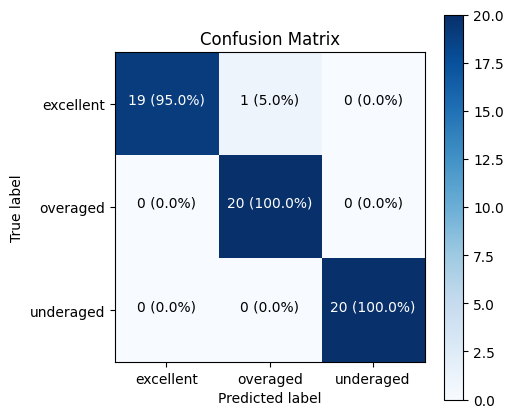

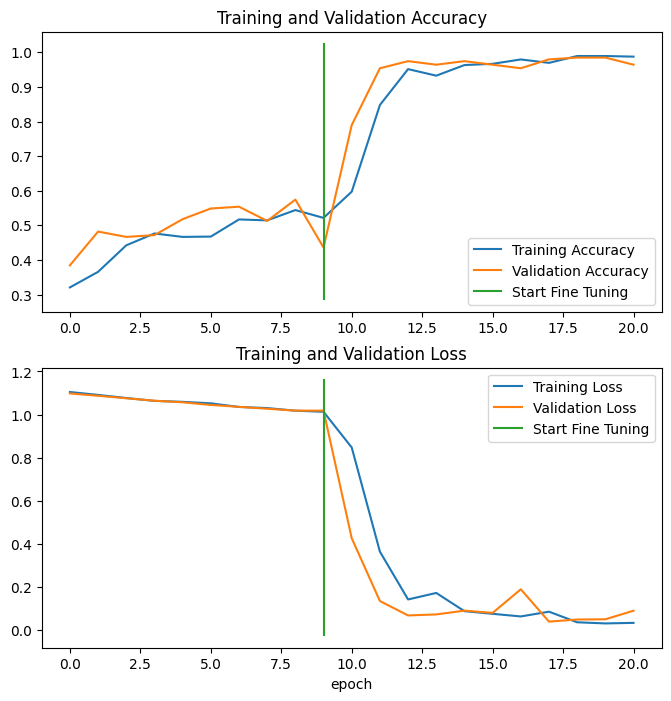

In [29]:
#Generate needed details
model_6.load_weights(checkpoint_path)
generate_details(model_6,test_data,[history6,history6_tuned,10],True)

# Model 7 MobileNetv2

In [30]:
base_model = tf.keras.applications.MobileNetV2(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = layers.Rescaling(1./255)(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(3, activation="softmax", name="output_layer")(x)
model_7 = tf.keras.Model(inputs, outputs)
model_7.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_7.name = "Model_7_MobileNetV2"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_7.name)
logger = setup_csvlogger(model_7.name)

history7 = model_7.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback,logger]
                      )

/tmp/ipykernel_220427/4223800861.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(include_top=False)


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.4504 - loss: 1.0706
Epoch 1: val_loss improved from inf to 0.67143, saving model to runs/checkpoints/Model_7_MobileNetV2.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.4529 - loss: 1.0669 - val_accuracy: 0.7692 - val_loss: 0.6714
Epoch 2/10
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7764 - loss: 0.6176 
Epoch 2: val_loss improved from 0.67143 to 0.45457, saving model to runs/checkpoints/Model_7_MobileNetV2.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.7785 - loss: 0.6143 - val_accuracy: 0.8718 - val_loss: 0.4546
Epoch 3/10
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8692 - loss: 0.4444
Epoch 3: val_loss improved from 0.45457 to 0.38114, saving model to runs/checkpoints/Model_7_MobileNetV2.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.8699 - loss: 0.4432 - val_accuracy: 0.9026 - val_loss: 0.3811
Epoch 4/10
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/s

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step - accuracy: 0.9451 - loss: 0.2614
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 726ms/step
done.
Close? True | Difference: -5.563100180516756e-08


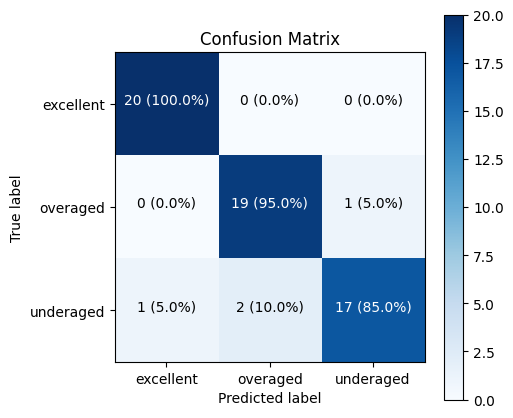

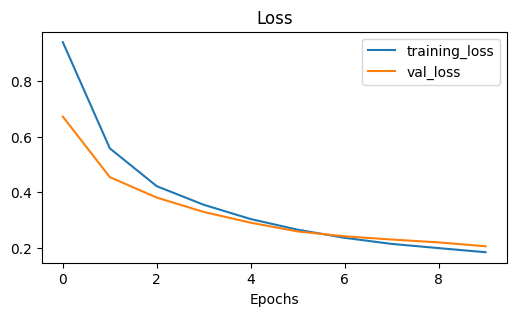

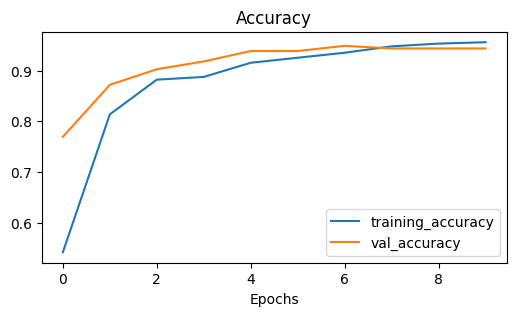

In [31]:
#Generate needed details
model_7.load_weights(checkpoint_path)
generate_details(model_7,test_data,[history7])

# Model 7 MobileNetv2 with fine-tuning

In [32]:
model_7.load_weights(checkpoint_path)
model_7.layers[2].trainable = False

for layer in model_7.layers[2].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_7.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), #set lower training rate 0.001 is default
              metrics=["accuracy"],
              jit_compile = False)

model_7.name = "Model_7_MobileNetV2_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_7.name)
logger = setup_csvlogger(model_7.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history7_tuned = model_7.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history7.epoch[-1],
                             callbacks=[checkpoint_callback,logger]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9087 - loss: 0.2312
Epoch 10: val_loss improved from inf to 0.24132, saving model to runs/checkpoints/Model_7_MobileNetV2_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9088 - loss: 0.2312 - val_accuracy: 0.9128 - val_loss: 0.2413
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9477 - loss: 0.1533
Epoch 11: val_loss improved from 0.24132 to 0.14926, saving model to runs/checkpoints/Model_7_MobileNetV2_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9480 - loss: 0.1528 - val_accuracy: 0.9436 - val_loss: 0.1493
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9740 - loss: 0.0946
Epoch 12: val_loss improved from 0.14926 to 0.13336, saving model to runs/checkpoints/Model_7_MobileNetV2_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9741 - loss: 0.0943 - val_accuracy: 0.9641 - val_loss: 

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9674 - loss: 0.1243
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 720ms/step
done.
Close? True | Difference: -8.74201456779744e-08


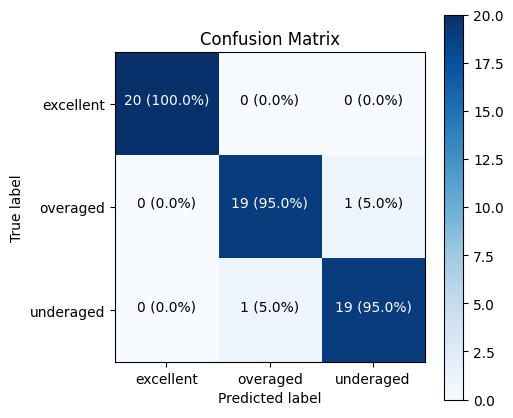

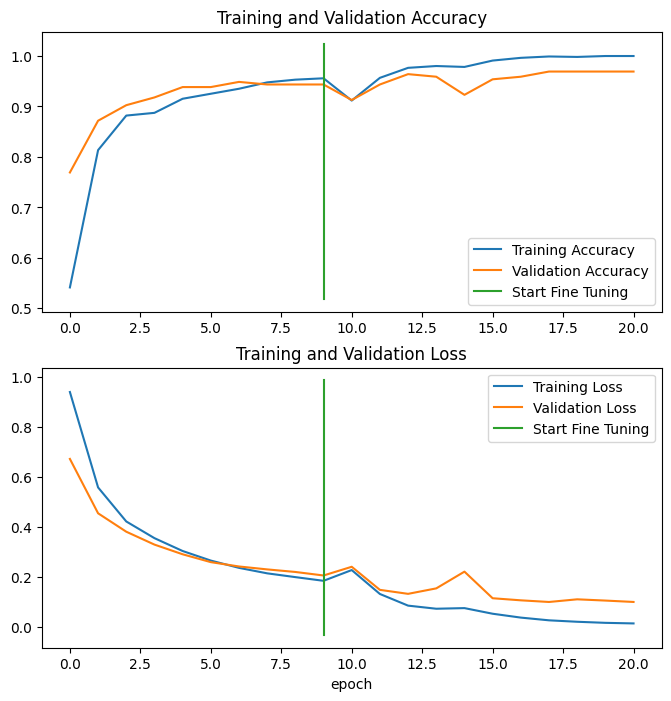

In [33]:
#Generate needed details
model_7.load_weights(checkpoint_path)
generate_details(model_7,test_data,[history7,history7_tuned,10],True)

# Model 8 MobileNetv2 with augmentation

In [34]:
data_augmentation = keras.Sequential([
  layers.RandomZoom(0.1,0.3),
  layers.RandomFlip("horizontal"),
], name ="data_augmentation")

input_shape = (224, 224, 3)
base_model = tf.keras.applications.MobileNetV2(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = layers.Rescaling(1./255, name="rescaler")(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)
model_8 = keras.Model(inputs, outputs)

model_8.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_8.name = "Model_8_MobileNetV2_with_augmentation"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_8.name)
logger = setup_csvlogger(model_8.name)

history8 = model_8.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback,logger]
                      )

/tmp/ipykernel_220427/3415732155.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(include_top=False)


Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4100 - loss: 1.1408
Epoch 1: val_loss improved from inf to 0.78618, saving model to runs/checkpoints/Model_8_MobileNetV2_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.4128 - loss: 1.1372 - val_accuracy: 0.6667 - val_loss: 0.7862
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7179 - loss: 0.6955
Epoch 2: val_loss improved from 0.78618 to 0.56953, saving model to runs/checkpoints/Model_8_MobileNetV2_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.7190 - loss: 0.6941 - val_accuracy: 0.7795 - val_loss: 0.5695
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8389 - loss: 0.5214
Epoch 3: val_loss improved from 0.56953 to 0.44455, saving model to runs/checkpoints/Model_8_MobileNetV2_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.8389 - loss: 0.5208 - val_accuracy: 0.8410 - val_loss: 0

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8910 - loss: 0.3301
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 719ms/step
done.
Close? True | Difference: -6.755193071583676e-08


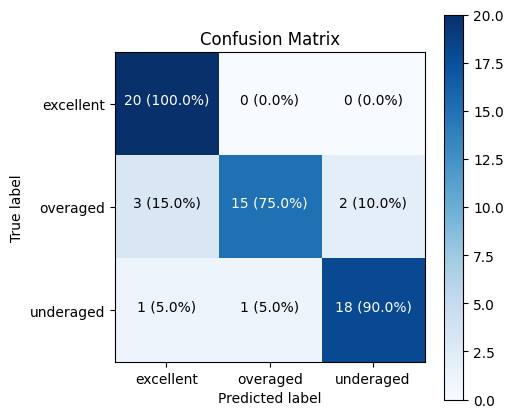

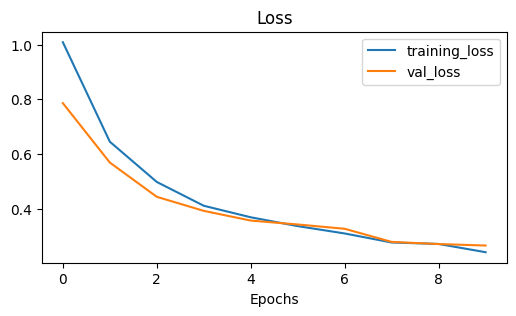

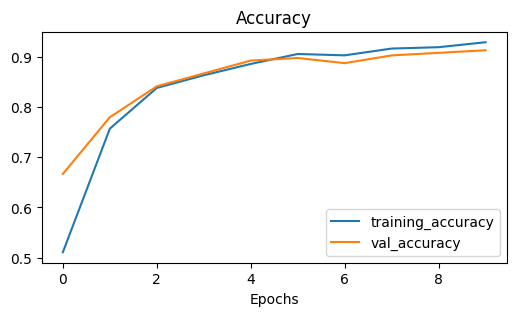

In [35]:
#Generate needed details
model_8.load_weights(checkpoint_path)
generate_details(model_8,test_data,[history8])

# Model 8 MobileNetv2 with augmentation and fine-tuning

In [36]:
model_8.load_weights(checkpoint_path)
model_8.layers[3].trainable = False

for layer in model_8.layers[3].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_8.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), #set lower training rate
              metrics=["accuracy"])

model_8.name = "Model_8_MobileNetV2_with_augmentation_and_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_8.name)
logger = setup_csvlogger(model_8.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history8_tuned = model_8.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history8.epoch[-1],
                             callbacks=[checkpoint_callback,logger]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8857 - loss: 0.2763
Epoch 10: val_loss improved from inf to 0.24148, saving model to runs/checkpoints/Model_8_MobileNetV2_with_augmentation_and_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.8861 - loss: 0.2757 - val_accuracy: 0.8923 - val_loss: 0.2415
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9188 - loss: 0.2232
Epoch 11: val_loss did not improve from 0.24148
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9193 - loss: 0.2225 - val_accuracy: 0.8615 - val_loss: 0.2890
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9440 - loss: 0.1773
Epoch 12: val_loss did not improve from 0.24148
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9440 - loss: 0.1770 - val_accuracy: 0.8564 - val_loss: 0.3692
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9554 - loss: 0.1312
Epoch 13: val_loss did not improve from 0.24148
35/35 ━━━━

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8479 - loss: 0.2855 
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 748ms/step
done.
Close? True | Difference: -3.5762786843029915e-08


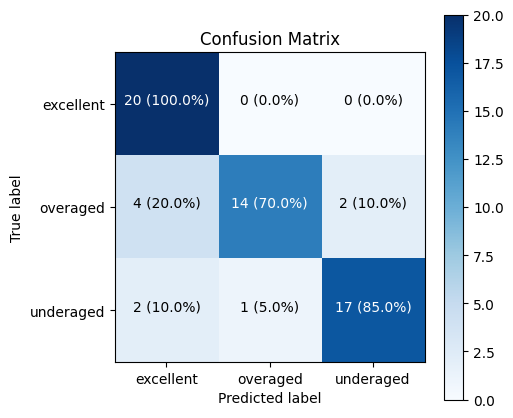

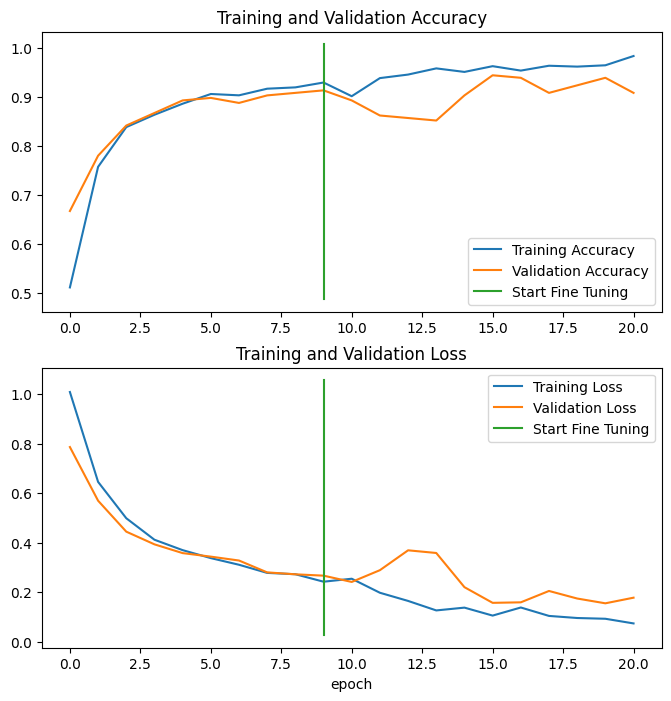

In [37]:
#Generate needed details
model_8.load_weights(checkpoint_path)
generate_details(model_8,test_data,[history8,history8_tuned,10],True)

# RESULT SUMMARY

In [38]:
show_results(res)

,Model,Loss,Accuracy
0,Model_1_EfficientNetB0,15.8493,100.0000
1,Model_1_EfficientNetB0_with_fine-tuning,1.9118,100.0000
2,Model_2_EfficientNetB0_with_augmentation,22.3239,91.6667
3,Model_2_EfficientNetB0_with_augmentation_and_f...,6.6014,96.6667
4,Model_3_ResNet50v2,21.0117,93.3333
5,Model_3_ResNet50v2_with_fine-tuning,12.4118,95.0000
6,Model_4_ResNet50v2_with_augmentation,27.6854,93.3333
7,Model_4_ResNet50v2_with_augmentation_with_fine...,11.4446,96.6667
8,Model_5_VGG16,98.5554,63.3333
9,Model_5_VGG16_with_fine-tuning,1.5178,98.3333


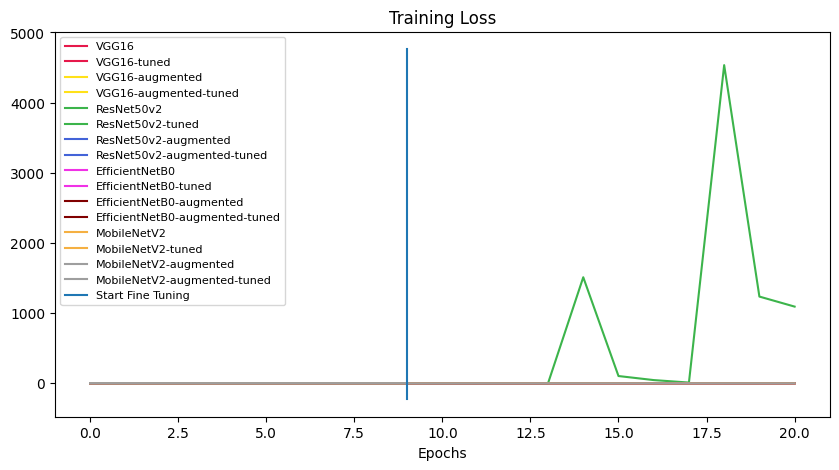

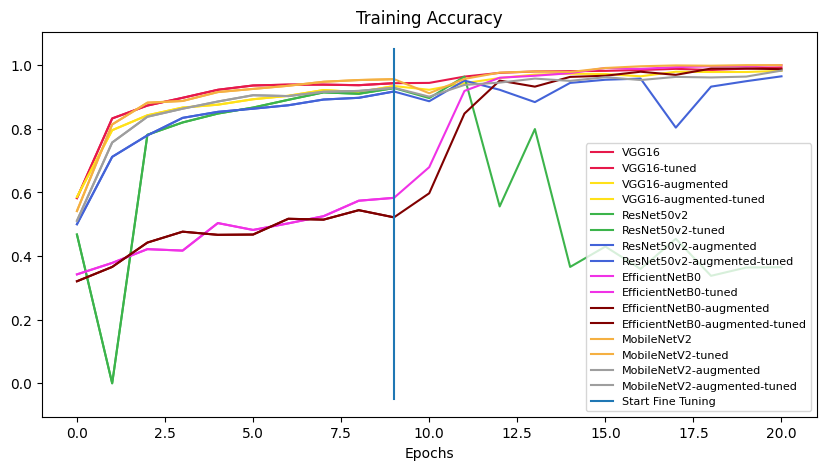

In [39]:
plot_all_curves(
    history=[history1,
             history2,
             history3,
             history4,
             history5,
             history6,
             history7,
             history8,
            ],
    new_history=[
        history1_tuned,
        history2_tuned,
        history3_tuned,
        history4_tuned,
        history5_tuned,
        history6_tuned,
        history7_tuned,
        history8_tuned
        ],
    model_name="all",train_val="train")

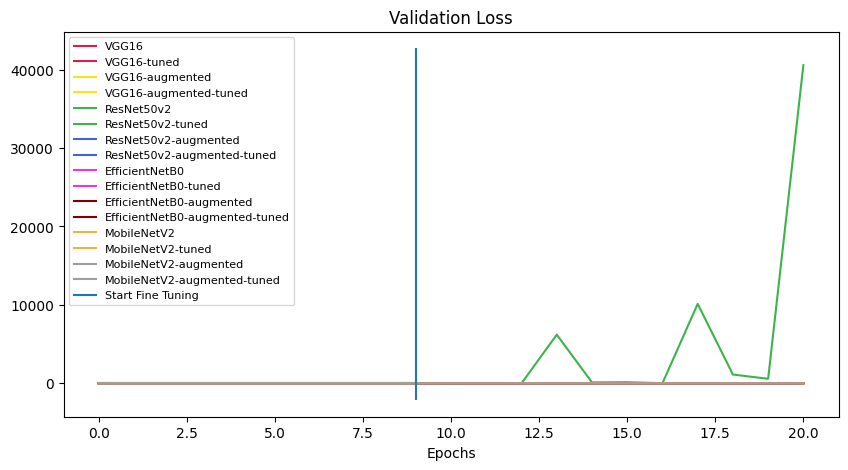

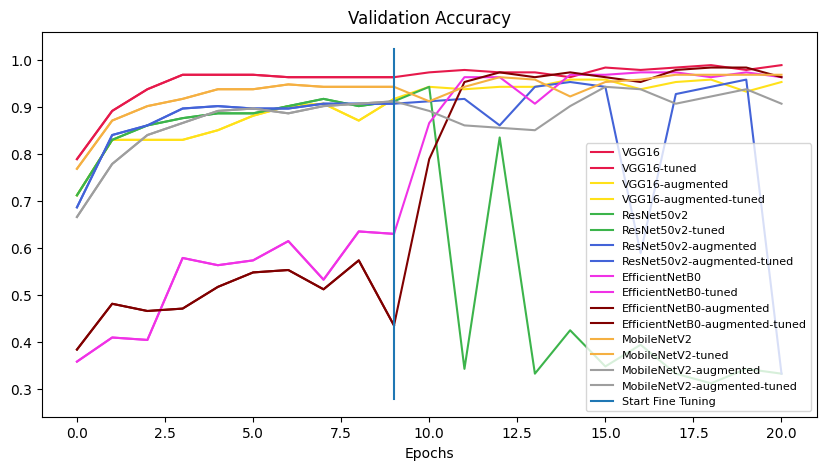

In [40]:
plot_all_curves(
    history=[history1,
             history2,
             history3,
             history4,
             history5,
             history6,
             history7,
             history8,
            ],
    new_history=[
        history1_tuned,
        history2_tuned,
        history3_tuned,
        history4_tuned,
        history5_tuned,
        history6_tuned,
        history7_tuned,
        history8_tuned
        ],
    model_name="all",train_val="val")